In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

import copy
import itertools 

from scipy import stats
from scipy.stats import beta
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

In [2]:
# df_results = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\ufc_da2_model_results_test.csv')
df_history = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_train_v2.csv')
# df_results = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_v2.csv')
df_results = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_dualnn.csv')

df_results['pred_winner'] = np.where(df_results['correct_pred']==1, df_results['winner'], np.abs(1-df_results['winner']))
df_results['Date'] = df_results["event_dates"].copy()
df_results.sort_values(by='Date', ascending=True).reset_index(drop=True)

df_results['prob_winner'] = df_results[['red_probs','blue_probs']].max(axis=1)
df_results['winner_odds'] = np.where(df_results['winner'] == 1, df_results['open_red'], df_results['open_blue'])
df_results['choice_fighter_bet'] = np.where(df_results['pred_winner'] == 1, df_results['open_red'], df_results['open_blue'])
df_results['Date'] = df_results["Date"].astype(str)

df_correct_pred = df_results[df_results["correct_pred"] == 1].copy() 
df_incorrect_pred = df_results[df_results["correct_pred"] == 0].copy()

pred_correct_odds = df_results[df_results["correct_pred"] == 1]['choice_fighter_bet'].value_counts().sort_index()
pred_incorrect_odds = df_results[df_results["correct_pred"] == 0]['choice_fighter_bet'].value_counts().sort_index()

df_results.head()

,Unnamed: 0,blue_probs,red_probs,pred_winner,winner,correct_pred,event_dates,open_red,open_blue,close1_red,close1_blue,close2_red,close2_blue,red_fighter,blue_fighter,Date,prob_winner,winner_odds,choice_fighter_bet
0,0,0.443728,0.556272,1,0,0,2023-08-12,163.0,-200.0,164.0,-225.0,180.0,-198.0,josh parisian,martin buday,2023-08-12,0.556272,-200.0,163.0
1,1,0.586791,0.413209,0,0,1,2023-08-12,300.0,-400.0,260.0,-450.0,350.0,-335.0,jp buys,marcus mcghee,2023-08-12,0.586791,-400.0,-400.0
2,2,0.705298,0.294702,0,0,1,2023-08-12,163.0,-200.0,158.0,-200.0,170.0,-188.0,polyana viana,iasmin lucindo,2023-08-12,0.705298,-200.0,-200.0
3,3,0.477116,0.522884,1,1,1,2023-08-12,-225.0,175.0,-200.0,140.0,-170.0,170.0,khalil rountree jr,chris daukaus,2023-08-12,0.522884,-225.0,-225.0
4,4,0.712623,0.287377,0,1,0,2023-08-12,200.0,-250.0,175.0,-320.0,250.0,-225.0,cub swanson,hakeem dawodu,2023-08-12,0.712623,200.0,-250.0


In [ ]:
from collections import defaultdict
def fighter_prediction_stats(df, pred_col='pred_winner', red_col='red_fighter', blue_col='blue_fighter', winner_col='winner'):
    
    stats = defaultdict(lambda: {'correct': 0, 'incorrect': 0})
    for _, row in df.iterrows():
        red_fighter = row[red_col]
        blue_fighter = row[blue_col]
        winner = row[winner_col]
        pred = row[pred_col]
        if pred == winner :
            if pred == 1: 
                stats[red_fighter]['correct'] += 1
            else: 
                stats[blue_fighter]['correct'] += 1
        else:
            if pred == 1: 
                stats[red_fighter]['incorrect'] += 1
            else:
                stats[blue_fighter]['incorrect'] += 1
    return stats

preds_results_dict = fighter_prediction_stats(df_history)

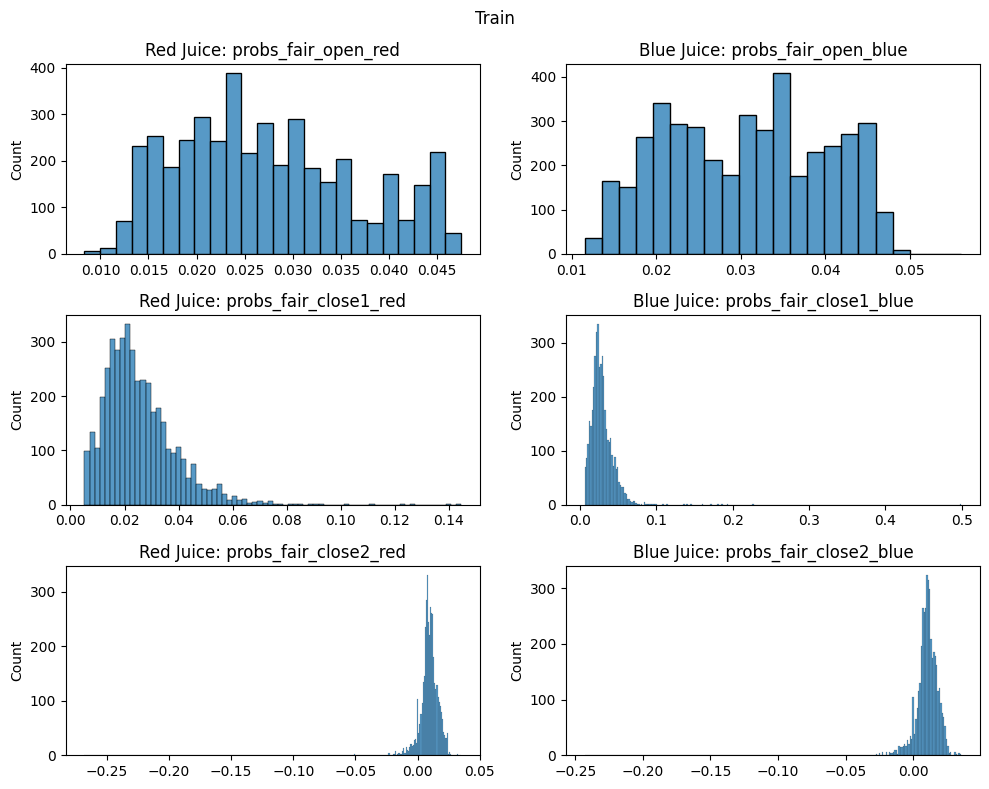

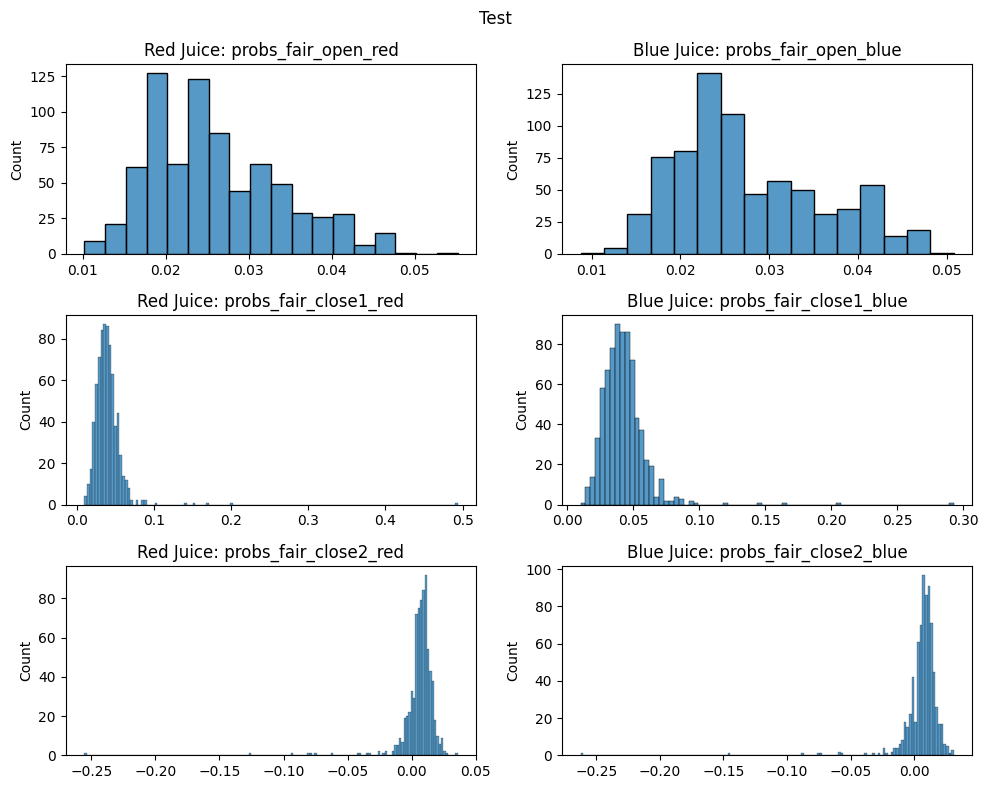

In [ ]:
def plot_juice(df, red_fair, blue_fair, red_imp, blue_imp, title):

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,8))
    for i, ax in enumerate(axes):
        red_juice = df[red_imp[i]] - df[red_fair[i]]   
        sns.histplot(red_juice, ax=ax[0]) 
        ax[0].set_title(f'Red Juice: {red_fair[i]}')

        blue_juice = df[blue_imp[i]] - df[blue_fair[i]]
        sns.histplot(blue_juice, ax=ax[1])
        ax[1].set_title(f'Blue Juice: {blue_fair[i]}')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_juice(df_history, red_fair, blue_fair, red_imp, blue_imp, 'Train')
plot_juice(df_results, red_fair, blue_fair, red_imp, blue_imp, 'Test')

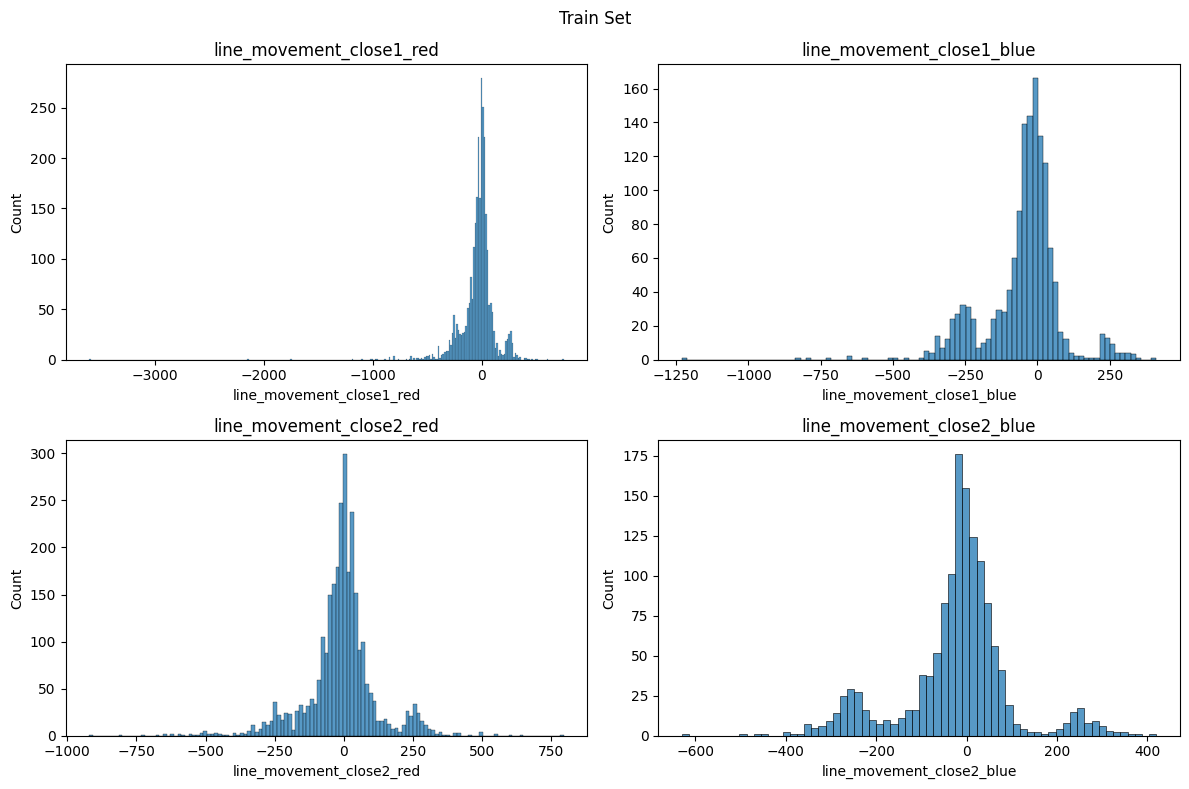

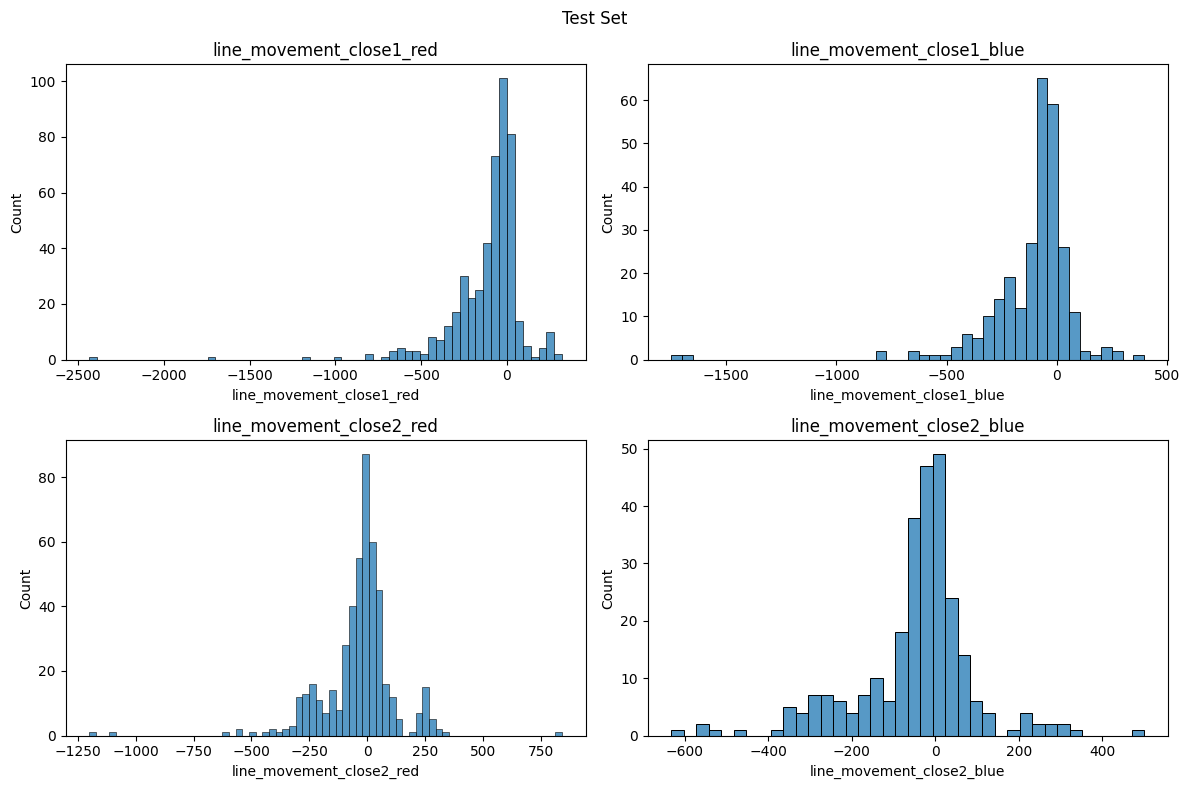

In [11]:
def plot_proba_diffs(df, title):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8))

    sns.histplot(df['proba_red_open_diff'], ax=axes[0,0])
    sns.histplot(df['proba_blue_open_diff'], ax=axes[0,1])
    axes[0,0].set_title('proba diffs red open')
    axes[0,1].set_title('proba diffs blue open')

    sns.histplot(df['proba_red_close1_diff'], ax=axes[1,0])
    sns.histplot(df['proba_blue_close1_diff'], ax=axes[1,1])
    axes[1,0].set_title('proba diffs red close1')
    axes[1,1].set_title('proba diffs blue close1')

    sns.histplot(df['proba_red_close2_diff'], ax=axes[2,0])
    sns.histplot(df['proba_blue_close2_diff'], ax=axes[2,1])
    axes[2,0].set_title('proba diffs red close2')
    axes[2,1].set_title('proba diffs blue close2')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def plot_line_movement(df, title):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
    blue_idxs = df['pred_winner']==0
    red_idxs = df['pred_winner']==1
    sns.histplot(df['line_movement_close1_red'][red_idxs], ax=axes[0,0])
    sns.histplot(df['line_movement_close1_blue'][blue_idxs], ax=axes[0,1])
    axes[0,0].set_title('line_movement_close1_red')
    axes[0,1].set_title('line_movement_close1_blue')

    sns.histplot(df['line_movement_close2_red'][red_idxs], ax=axes[1,0])
    sns.histplot(df['line_movement_close2_blue'][blue_idxs], ax=axes[1,1])
    axes[1,0].set_title('line_movement_close2_red')
    axes[1,1].set_title('line_movement_close2_blue')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_line_movement(df_history, 'Train Set')
plot_line_movement(df_results, 'Test Set')

In [ ]:
def expected_value(p, o):
    EV = p * (o - 1) - (1 - p) * 1
    return EV 

def log_return_volatility(f, b, p):
    """
    Compute per-bet log-return volatility (sigma) and expected log return (mu).
    
    f : fraction of bankroll bet
    b : net odds (decimal odds - 1)
    p : probability of winning
    """
    r_win = np.log(1 + f * b)
    r_lose = np.log(1 - f)
    mu = p * r_win + (1 - p) * r_lose
    sigma2 = p * (r_win - mu)**2 + (1 - p) * (r_lose - mu)**2
    sigma = np.sqrt(sigma2)
    return sigma, mu

def expected_max_drawdown(sigma, N):
    """
    Heuristic for expected maximum drawdown over N bets
    """
    return sigma * np.sqrt(2 * np.log(N))

def scale_kelly_for_mdd(p, odds, f_full, N, max_drawdown, tol=1e-4):
    """
    Find the largest fraction of full Kelly that keeps expected MDD <= max_drawdown
    
    p : probability of winning
    odds : decimal odds
    f_full : full Kelly fraction (fraction of bankroll)
    N : number of bets
    max_drawdown : tolerable drawdown fraction (0 < max_drawdown < 1)
    tol : numerical tolerance for convergence
    """
    b = odds - 1
    # binary search between 0 and 1 (fraction of full Kelly)
    low, high = 0.0, 1.0
    best_fraction = 0.0
    
    while high - low > tol:
        k = (low + high) / 2
        f_trial = k * f_full
        sigma, mu = log_return_volatility(f_trial, b, p)
        mdd_est = expected_max_drawdown(sigma, N)
        
        if mdd_est <= max_drawdown:
            best_fraction = k  # this fraction is safe, try higher
            low = k
        else:
            high = k  # too aggressive, try lower
            
    return best_fraction * f_full

def scale_kelly_portfolio(bets, N, max_drawdown):
    """
    Scale multiple simultaneous Kelly bets to meet portfolio MDD target.
    
    bets : list of dicts with keys ['p', 'odds', 'f_full']
    N : number of rounds
    max_drawdown : tolerable drawdown fraction
    """
    mus = []
    sigmas = []
    sharpe_ratio_bet = []
    f_full_list = []

    for bet in bets:
        f = bet.get('f_full', 0)
        b = bet.get('odds', 0) - 1
        p = bet.get('p', 0)

        # ✅ Skip invalid or non-betting entries
        if f <= 0 or p <= 0 or b <= 0:
            mus.append(0)
            sigmas.append(0)
            sharpe_ratio_bet.append(0)
            f_full_list.append(0)
            continue

        sigma, _ = log_return_volatility(f, b, p)
        mu_ev = expected_value(p, b + 1) * f  # scaled EV by fraction
        mus.append(mu_ev)
        sigmas.append(sigma)
        sharpe_ratio_bet.append(mu_ev / sigma if sigma > 0 else 0)
        f_full_list.append(f)

    mus = np.array(mus)
    sigmas = np.array(sigmas)
    f_full_list = np.array(f_full_list)

    # ✅ If all f_full = 0 → no bets made → return zeros safely
    if np.all(f_full_list == 0):
        return (
            np.zeros_like(f_full_list),
            0,  # sigma_portfolio
            0,  # sigma_portfolio_scaled
            0,  # mu_portfolio
            0,  # sharpe_ratio_portfolio
            np.zeros_like(f_full_list),  # sharpe_ratio_bet
            np.zeros_like(f_full_list),  # sigmas
            0   # k
        )

    # ✅ Compute portfolio stats only for active bets
    sigma_portfolio = np.sqrt(np.sum((f_full_list * sigmas) ** 2))
    mu_portfolio = np.sum(f_full_list * mus)
    sharpe_ratio_portfolio = mu_portfolio / sigma_portfolio if sigma_portfolio > 0 else 0

    # ✅ Compute scaling factor
    k = max_drawdown / (sigma_portfolio * np.sqrt(2 * np.log(N))) if sigma_portfolio > 0 else 0
    k = min(k, 1.0)  # cannot exceed full Kelly

    f_scaled = k * f_full_list
    sigma_portfolio_scaled = k * sigma_portfolio

    return (
        f_scaled,
        sigma_portfolio,
        sigma_portfolio_scaled,
        mu_portfolio,
        sharpe_ratio_portfolio,
        sharpe_ratio_bet,
        sigmas,
        k
    )

def calc_juice(real_odds, devigged_odds, as_prob=True):
    """
    real_odds, devigged_odds : scalar or array-like (decimal odds or probabilities)
    If inputs look like probabilities (all <= 1), they're treated as probs.
    Returns: juice = p_book - p_fair (probability units).
    """
    real = np.asarray(real_odds, dtype=float)
    devig = np.asarray(devigged_odds, dtype=float)

    # Detect if inputs are decimal odds (>1) or already probabilities (<=1)
    def to_prob(x):
        if np.all(x <= 1.0 + 1e-12):   # already probabilities
            return x
        return 1.0 / x

    p_book = to_prob(real)
    p_fair = to_prob(devig)

    juice = p_book - p_fair

    juice_pct_of_fair = np.divide(juice, p_fair, out=np.zeros_like(juice), where=p_fair!=0)
    ev_per_dollar = -juice / p_book   # EV = -juice / p_book  (see earlier derivation)
    return juice, juice_pct_of_fair, ev_per_dollar

In [ ]:
def pca_nearest_neighbors_test(df, nn_cols, pca, nn, scaler):

    X = df[nn_cols]
    X_scaled = scaler.transform(X)
    X_projected = pca.transform(X_scaled)

    distances, indices = nn.kneighbors(X_projected)
    all_neighbor_indices = np.unique(indices.flatten())
    neighbors = df.iloc[all_neighbor_indices]
    return neighbors, distances  

def pca_nearest_neighbors_train(df, nn_cols, n_components, n_neighbors): 
    X = df[nn_cols]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components)
    X_projected = pca.fit_transform(X_scaled)
    
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(X_projected)
    return pca, nn, scaler    

def inference_pca_nn(df):
    scaler = StandardScaler()
    ipca = IncrementalPCA(n_components=5, batch_size=100)

    pca_types = ['entire_history', 'stayed_dog', 'stayed_fav', 'dog_to_fav', 'fav_to_dog']
    pca_dict = {key:IncrementalPCA() for key in pca_types}
    scaler_dict = {key:StandardScaler() for key in pca_types}

    X_scaled_history = scaler.fit_transform(df_history[continuous_cols])
    df_past = df[df['Date'] < current_date]
    X_scaled = scaler.transform(df_past[continuous_cols])

    nn = NearestNeighbors(n_neighbors=5, metric='euclidean')
    nn.fit(X_scaled)
    distances, indices = nn.kneighbors(X_scaled)

def run_parlay_function(group, choice_idx, choice_proba, choice_fair_odds, choice_real_odds, bankroll):
    parlay_df = pd.DataFrame()
    parlay_df['winner'] = group['winner']
    parlay_df['pred_winner'] = choice_idx
    parlay_df['choice_proba'] = choice_proba
    parlay_df['choice_fair_odds'] = choice_fair_odds
    parlay_df['choice_real_odds'] = choice_real_odds
    parlay_df['red_fighter'] = group['red_fighter']
    parlay_df['blue_fighter'] = group['blue_fighter']
    parlay_results_df = most_probable_parlay(parlay_df, max_legs=3, top_n=2)
    parlay_net = np.sum(
        np.where(
            parlay_results_df['parlay_won'] == 1,
            parlay_results_df['kelly_fraction'] * bankroll * parlay_results_df['potential_winnings'],
            -parlay_results_df['kelly_fraction'] * bankroll
        )
    )
    return parlay_results_df, parlay_net
def kelly_fraction(p, b):
    """Return Kelly fraction for given probability p and decimal odds b+1."""
    q = 1 - p
    f = (b * p - q) / b
    return max(f, 0)  # only positive bets

def expected_log_growth(p, b, f):
    """Expected log bankroll growth under Kelly bet fraction f."""
    return p * np.log(1 + f * b) + (1 - p) * np.log(1 - f)

def most_probable_parlay(df, min_legs=2, max_legs=5, top_n=4):
    """
    Find the top-N parlays with the highest total probability of winning,
    restricted to parlays of at least `min_legs` fights.
    
    Parameters
    ----------
    df : DataFrame
        Must include columns:
        ['fight', 'choice_proba', 'choice_real_odds', 'winner', 'pred_winner', 'red_fighter', 'blue_fighter']
    min_legs : int
        Minimum number of fights to include in a parlay (must be >= 2).
    max_legs : int
        Maximum number of fights to include in a parlay.
    top_n : int
        Number of top parlays to return.
    """
    if min_legs < 2:
        raise ValueError("min_legs must be at least 2")
    
    results = []

    # Iterate over all combinations of fights from min_legs to max_legs
    for r in range(min_legs, max_legs + 1):
        for combo in itertools.combinations(df.itertuples(), r):
            probs = [c.choice_proba for c in combo]
            decs = [c.choice_real_odds for c in combo]
            winners = [c.winner for c in combo]
            preds = [c.pred_winner for c in combo]

            parlay_prob = np.prod(probs)
            parlay_odds = np.prod(decs)
            b = parlay_odds - 1

            parlay_won = all(w == p for w, p in zip(winners, preds))
            potential_winnings = b  # profit per 1-unit stake
            expected_value = parlay_prob * b - (1 - parlay_prob)

            results.append({
                "parlay_fights": [(c.red_fighter, c.blue_fighter) for c in combo],
                'parlay_fight_odds':[c.choice_proba for c in combo],
                "num_legs": r,
                "parlay_prob": parlay_prob,
                "parlay_odds": parlay_odds,
                "potential_winnings": potential_winnings,
                "expected_value": expected_value,
                "winners": winners,
                "pred_winners": preds,
                "parlay_won": parlay_won
            })

    results_df = (
        pd.DataFrame(results)
        .sort_values("parlay_prob", ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )

    print("\nTop Parlays by Probability:")
    print(results_df[["parlay_fight_odds", "expected_value", "potential_winnings",'parlay_won']].head(4))
    
    return results_df


In [ ]:
# https://vegapit.com/article/numerically_solve_kelly_criterion_multiple_simultaneous_bets/
# https://nickyoder.com/kelly-criterion/
# https://www.mma-ai.net/ 

# https://business.columbia.edu/sites/default/files-efs/pubfiles/6343/bayes_kelly.pdf
## Portfolio Choice and the Bayesian Kelly Criterion

def kelly_edge(p, fair_decimal):
    edge = p - (1/(fair_decimal + 1))
    edge = p - (1/(fair_decimal ))
    return edge

def bayesian_edge(p, fair_decimal, correct, incorrect):
    # Beta posterior: alpha = 1 + correct, beta = 1 + incorrect
    posterior = beta(a=1+correct, b=1+incorrect)
    adjusted_prob = posterior.mean()

    # Adjusted Kelly edge
    posterior_var = posterior.var()
    confidence = 1-posterior_var 
    edge = p - (1 /(fair_decimal+(.25*confidence))) # inflate edge? 
    return edge, adjusted_prob

def calculate_results_history(results_dict, row, bet_idx, p, fair_odds):
    correct_red = results_dict[row['red_fighter']]['correct']
    incorrect_red = results_dict[row['red_fighter']]['incorrect']
    correct_blue = results_dict[row['blue_fighter']]['correct']
    incorrect_blue = results_dict[row['blue_fighter']]['incorrect']
    pred = bet_idx
    if pred == 1:
        kelly_frac, posterior = bayesian_edge(p, fair_odds, correct_red, incorrect_red)
    else:
        kelly_frac, posterior = bayesian_edge(p, fair_odds, correct_blue, incorrect_blue)

    winner = row['winner']
    red_fighter = row['red_fighter']
    blue_fighter = row['blue_fighter']
    if pred == winner :
        if pred == 1: 
            results_dict[red_fighter]['correct'] += 1
        else: 
            results_dict[blue_fighter]['correct'] += 1
    else:
        if pred == 1: 
            results_dict[red_fighter]['incorrect'] += 1
        else:
            results_dict[blue_fighter]['incorrect'] += 1
    return results_dict, kelly_frac, posterior

def run_portfolio_scaling(choice_ev, choice_proba, unweighted_fstar, choice_fair_odds, max_drawdown, bankroll, choice_real_odds, choice_idx, winner_col, group, group_stats, group_profit):
    bets = []
    for i in range(len(choice_proba)):
        if choice_ev[i] > 0 and unweighted_fstar[i] > 0:
            bets.append({
                'p': choice_proba[i],
                'odds': choice_fair_odds[i],
                'f_full': unweighted_fstar[i]
            })
        else:
            bets.append({
                'p': choice_proba[i],
                'odds': choice_fair_odds[i],
                'f_full': 0
            })

    f_scaled, sigma_portfolio, sigma_portfolio_scaled, mu_portfolio, sharpe_portfolio, sharpe_per_bet, sigma_per_bet, k = \
        scale_kelly_portfolio(bets, N=1000, max_drawdown=max_drawdown)
    
    for i, (kelly_frac, p, real_odds, ev, bet_idx) in enumerate(zip(f_scaled, choice_proba, choice_real_odds, choice_ev, choice_idx)):
        stake = bankroll * kelly_frac
        if kelly_frac < 0 or ev <0 : 
            profit = 0
            net_odds = 0
        else: 
            profit = stake * (real_odds - 1) if int(group.iloc[i][winner_col]) == bet_idx else -stake
            net_odds = (real_odds - 1) if int(group.iloc[i][winner_col]) == bet_idx else -(real_odds - 1)
        group_stats['choice_fstar'].append(kelly_frac)
        group_stats['fight_payout'].append(profit)
        group_stats['net_odds'].append(net_odds)
        group_profit += profit
    
    return group_stats, sigma_portfolio, sigma_portfolio_scaled, mu_portfolio, sharpe_portfolio, sharpe_per_bet, sigma_per_bet, k, group_stats, group_profit

def run_per_bet_scaling(choice_ev, choice_proba, unweighted_fstar, choice_fair_odds, max_drawdown, bankroll, choice_real_odds, choice_idx, winner_col, group, group_stats, posterior, N, group_profit):
    for i, (f_star, p, fair_odds, real_odds, ev, bet_idx) in enumerate(zip(unweighted_fstar, choice_proba, choice_fair_odds, choice_real_odds, choice_ev, choice_idx)):
        if f_star < 0 or ev < 0:                 
            profit = 0
            f_final = f_star
            net_odds = 0
        else:
            f_final = scale_kelly_for_mdd(p, fair_odds, f_star, N=N, max_drawdown=max_drawdown)  
            stake = bankroll * f_final
            profit = stake * (real_odds - 1) if int(group.iloc[i][winner_col]) == bet_idx else -stake
            net_odds = (real_odds - 1) if int(group.iloc[i][winner_col]) == bet_idx else -(real_odds - 1)

        group_stats['choice_fstar'].append(f_final)
        group_stats['fight_payout'].append(profit)
        group_stats['net_odds'].append(net_odds)
        group_profit += profit

    # Portfolio metrics computed once per group
    bets = [{'p': choice_proba[i], 'odds': choice_real_odds[i], 'f_full': unweighted_fstar[i]}
        for i in range(len(choice_proba))]
        
    f_scaled, sigma_portfolio, sigma_portfolio_scaled, mu_portfolio, sharpe_portfolio, sharpe_per_bet, sigma_per_bet, k = \
        scale_kelly_portfolio(bets, N=N, max_drawdown=max_drawdown)
    
    return f_scaled, sigma_portfolio, sigma_portfolio_scaled, mu_portfolio, sharpe_portfolio, sharpe_per_bet, sigma_per_bet, k, group_stats, group_profit

def simulate_kelly(df, prob_cols, fair_decimal_cols, real_decimal_cols,
                           pred_winner_col, winner_col='winner', date_col='date',
                           init_bankroll=1000, bankroll_floor=None, portfolio_scaling=False,\
                            adaptive_scaling=False, max_drawdown=.30, N=1000,
                            preds_history_dict=None, calc_parlay=False, test_other_ev = False):
    
    if preds_history_dict is not None: 
        results_dict = copy.deepcopy(preds_history_dict)

    bankroll = init_bankroll
    df_results = pd.DataFrame()
    df = df.sort_values(by=date_col)

    for date, group in df.groupby(date_col, sort=True):
        group_profit = 0
        unweighted_fstar = []
        choice_proba = []
        choice_fair_odds = []
        choice_ev = []
        choice_real_odds = []
        choice_idx = []
        group_stats = {'fight_payout':[], 'choice_fstar':[], 'net_odds':[], 'choice_ev':[]}
        choice_posterior = []
        for idx, row in group.iterrows():
            posterior = 1
            choice_posterior.append(posterior)

            bet_idx = int(row[pred_winner_col])
            p = row[prob_cols[bet_idx]]
            fair_odds = row[fair_decimal_cols[bet_idx]]
            real_odds = row[real_decimal_cols[bet_idx]]
            ev = expected_value(p, real_odds)

            if ev <= 0 and test_other_ev is True: 
                new_bet = np.abs(bet_idx -1)
                ev = expected_value(1-p, row[fair_decimal_cols[new_bet]])
                if ev > 0: 
                    bet_idx = new_bet
                    real_odds = row[real_decimal_cols[bet_idx]]
                    fair_odds = row[fair_decimal_cols[bet_idx]]
                    p = 1-p

            if preds_history_dict is None: 
                kelly_default = kelly_edge(p, fair_odds) 
            else:
                results_dict, kelly_default, posterior = calculate_results_history(results_dict, row, bet_idx, p, fair_odds)

            unweighted_fstar.append(kelly_default)
            choice_proba.append(p)
            choice_fair_odds.append(fair_odds)
            choice_real_odds.append(real_odds)
            choice_ev.append(ev)
            choice_idx.append(bet_idx)
            choice_posterior.append(posterior)

        parlay_net = 0
        if calc_parlay is True: 
            parlay_df, parlay_net = run_parlay_function(group, choice_idx, choice_proba, choice_fair_odds, choice_real_odds, bankroll)

        if portfolio_scaling is True: 
            group_stats, sigma_portfolio, sigma_portfolio_scaled, mu_portfolio, sharpe_portfolio, sharpe_per_bet, sigma_per_bet, k, group_stats, group_profit = run_portfolio_scaling(choice_ev, choice_proba, unweighted_fstar, choice_fair_odds, max_drawdown, bankroll, choice_real_odds, choice_idx, winner_col, group, group_stats)

        elif adaptive_scaling is True: 
            f_scaled, sigma_portfolio, sigma_portfolio_scaled, mu_portfolio, sharpe_portfolio, sharpe_per_bet, sigma_per_bet, k, group_stats, group_profit = run_per_bet_scaling(choice_ev, choice_proba, unweighted_fstar, choice_fair_odds, max_drawdown, bankroll, choice_real_odds, choice_idx, winner_col, group, group_stats, posterior, N, group_profit)
        
        group_stats['sigma_portfolio_scaled'] = sigma_portfolio_scaled * np.ones(group.shape[0])
        group_stats['beta_post'] = choice_posterior
        group_stats['choice_ev'] = choice_ev
        group_stats['event_net_odds'] = np.ones(group.shape[0])*sum(group_stats['net_odds'])
        group_stats['event_payout'] = np.ones(group.shape[0])*group_profit
        group_stats['bankroll_postevent'] = np.ones(group.shape[0])*bankroll
        group_stats['portfolio_fscaled'] = f_scaled
        group_stats['portfolio_sigma'] = np.ones(group.shape[0])*sigma_portfolio
        group_stats['mu_portfolio'] =  np.ones(group.shape[0])*mu_portfolio
        group_stats['sharpe_portfolio'] = np.ones(group.shape[0])*sharpe_portfolio
        group_stats['sharpe_per_bet'] = sharpe_per_bet
        group_stats['sigma_per_bet'] = sigma_per_bet
        group_stats['k'] = np.ones(group.shape[0])*k
        group_stats['date'] = group['Date'].to_list()
        group_stats['red_fighter'] = group['red_fighter'].to_list()
        group_stats['blue_fighter'] = group['blue_fighter'].to_list()
        group_stats['choice_ev'] = choice_ev
        group_stats['choice_proba'] = choice_proba
        group_stats['red_proba'] = group['red_probs'].to_list()
        group_stats['blue_proba'] = group['blue_probs'].to_list()
        group_stats['pred_winner'] = group['pred_winner'].to_list()
        group_stats['winner'] = group['winner'].to_list()
        group_stats['choice_idx'] = choice_idx
        group_stats['open_red'] = group['open_red']
        group_stats['open_blue'] = group['open_blue']
        group_stats['kelly_edge'] = unweighted_fstar

        if calc_parlay is True: 
            group_profit += parlay_net
            group_stats['parlay_net'] = np.ones(group.shape[0]) * parlay_net

        bankroll += group_profit
        if bankroll_floor is not None and bankroll < bankroll_floor:
            print(f"Bankroll low on {date}, adding funds")
            bankroll += 1000

        if bankroll < init_bankroll:
            print(init_bankroll - bankroll)
            bankroll = 2000

        group_df = pd.DataFrame(group_stats)
        group_df[['juice_open_red', 'juice_open_blue', 'juice_close1_red',
                'juice_close1_blue', 'juice_close2_red', 'juice_close2_blue', 'open_red', 'open_blue',
                'close1_red', 'close1_blue', 'close2_red', 'close2_blue']] = group[['juice_open_red', 'juice_open_blue', 'juice_close1_red',
                'juice_close1_blue', 'juice_close2_red', 'juice_close2_blue',
                'open_red', 'open_blue', 'close1_red', 'close1_blue', 'close2_red', 'close2_blue']].copy() 

        df_results = pd.concat([df_results, group_df], ignore_index=True)

    plot_backtest(df_results, init_bankroll)
    return df_results 

def plot_backtest(df_results, init_bankroll):
    df_group = df_results.groupby('date').first().reset_index()  # take first row per date
    dates = df_group['date'].to_list()
    bankroll_history = df_group['bankroll_postevent'].values
    group_profit_history = df_group['event_payout'].values

    plt.figure(figsize=(12,5))
    x_positions = np.arange(len(dates))
    plt.plot(x_positions, bankroll_history, marker='o', label='Bankroll')
    plt.axhline(init_bankroll, color='gray', linestyle='--', label='Initial Bankroll')

    # Set x-ticks every label_every
    label_every = 5
    plt.xticks(
        x_positions[::label_every],
        [str(d) for i, d in enumerate(dates) if i % label_every == 0],
        rotation=45, ha='right'
    )

    # Compute average winning % per group
    proportion_wins = np.mean(group_profit_history > 0)

    plt.title(f'Bankroll over Time | Winning % of UFC Events: {proportion_wins:.2%}')
    plt.xlabel('Date')
    plt.ylabel('Bankroll')

    # Add legend
    legend = plt.legend(loc='upper left')
    # Compute events to reach milestones
    milestones = [10_000, 100_000, 1_000_000]
    milestone_texts = []
    for milestone in milestones:
        idx = np.argmax(bankroll_history >= milestone)
        if bankroll_history[idx] >= milestone:
            milestone_texts.append(f"{milestone:,}$ reached at event {idx+1}")
        else:
            milestone_texts.append(f"{milestone:,}$ not reached")

    # Display milestones in a bounding box under the legend
    plt.gca().text(
        1.02, 0.5, "\n".join(milestone_texts),
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
    )

    plt.tight_layout()
    plt.show()
                                  

24.690191786284004
494.2929167429231
716.788492032154


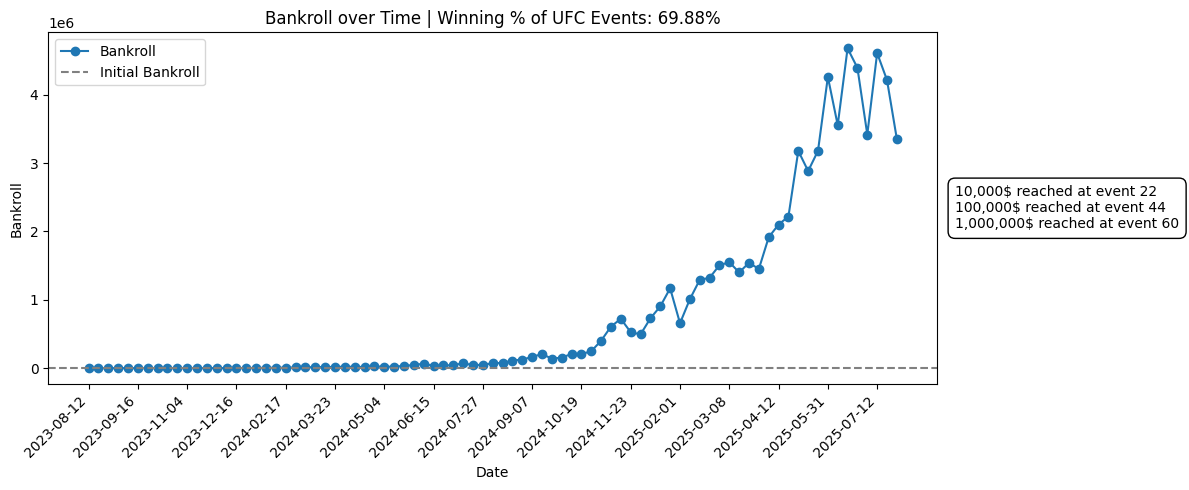

In [ ]:
prob_cols = ['blue_probs', 'red_probs']
fair_decimal_odds = ['dec_fair_open_blue', 'dec_fair_open_red']  # your decimal odds columns
real_decimal_odds = ['dec_open_blue', 'dec_open_red']
df_kelly = simulate_kelly(
    df_results,
    prob_cols=prob_cols,
    fair_decimal_cols=fair_decimal_odds,
    real_decimal_cols=real_decimal_odds,
    pred_winner_col='pred_winner',
    date_col='Date',
    init_bankroll=2000,
    bankroll_floor=100,
    portfolio_scaling=False,
    adaptive_scaling=True,
    max_drawdown=.4,
    N=1000,
    preds_history_dict=preds_results_dict,
    calc_parlay=False
)


In [ ]:
def kelly_analysis(df_kelly, x_vars, y_var, bins=8):

    # Standardize y_var
    fig, axes = plt.subplots(2, len(x_vars), figsize=(21, 18))

    # --- Row 1: Regression plots ---
    for i, x in enumerate(x_vars):
        r, p = stats.pearsonr(df_kelly[x], df_kelly[y_var])
        sns.regplot(
            data=df_kelly, x=x, y=y_var, ax=axes[0, i],
            scatter_kws={'s': 30}, line_kws={'color': 'red'}
        )
        axes[0, i].set_title(f"{x.replace('_', ' ').title()} (r={r:.2f}, p={p:.3f})", fontsize=11)
        axes[0, i].set_xlabel(x.replace('_', ' ').title())
        axes[0, i].set_ylabel('Standardized Event Payout')

    # --- Row 2: Bar plots with confidence intervals and one-sided t-tests ---
    for i, x in enumerate(x_vars):
        df_kelly[f'{x}_bin'] = pd.cut(df_kelly[x], bins=bins)
        
        agg_list = []
        for b in df_kelly[f'{x}_bin'].cat.categories:
            vals = df_kelly.loc[df_kelly[f'{x}_bin'] == b, y_var]
            n = len(vals)
            mean = vals.mean() if n > 0 else np.nan
            std = vals.std() if n > 1 else np.nan
            
            if n > 1:
                se = std / np.sqrt(n)
                ci = stats.t.interval(0.95, df=n-1, loc=mean, scale=se)
                if mean >= 0:
                    p_val = stats.ttest_1samp(vals, 0, alternative='greater').pvalue
                else:
                    p_val = stats.ttest_1samp(vals, 0, alternative='less').pvalue
            else:
                ci = (np.nan, np.nan)
                p_val = np.nan
            
            sig = f"n={n}, p={p_val:.3f}" if n > 0 else "n/a"
            agg_list.append({'bin': b, 'mean': mean, 'ci_lower': ci[0], 'ci_upper': ci[1], 'sig': sig})
        
        agg = pd.DataFrame(agg_list)
        sns.barplot(
            x='bin', y='mean', data=agg, ax=axes[1, i],
            palette='magma', edgecolor='black', linewidth=0.5
        )
        
        axes[1, i].errorbar(
            x=np.arange(len(agg)), 
            y=agg['mean'], 
            yerr=[agg['mean'] - agg['ci_lower'], agg['ci_upper'] - agg['mean']], 
            fmt='none', c='black', capsize=5
        )
        
        for j, row in agg.iterrows():
            y_pos = row['ci_upper'] + 0.04 * np.nanmax(np.abs(agg['mean']))
            axes[1, i].text(
                j, y_pos, row['sig'], ha='center', va='bottom', fontsize=9,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
            )
        
        axes[1, i].set_title(f'Avg Standardized Event Payout by {x.replace("_", " ").title()}', fontsize=11)
        axes[1, i].set_xlabel(x.replace('_', ' ').title())
        axes[1, i].set_ylabel('Average Standardized Event Payout')
        axes[1, i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

x_vars = ['mu_portfolio', 'sharpe_portfolio', 'portfolio_sigma']
y_var = 'event_net_odds'
kelly_analysis(df_kelly)

123.4759103257918
481.0349820882666
355.1221632771835
289.2849864086859
253.43130651237743
73.33056043307215
36.141960824950274


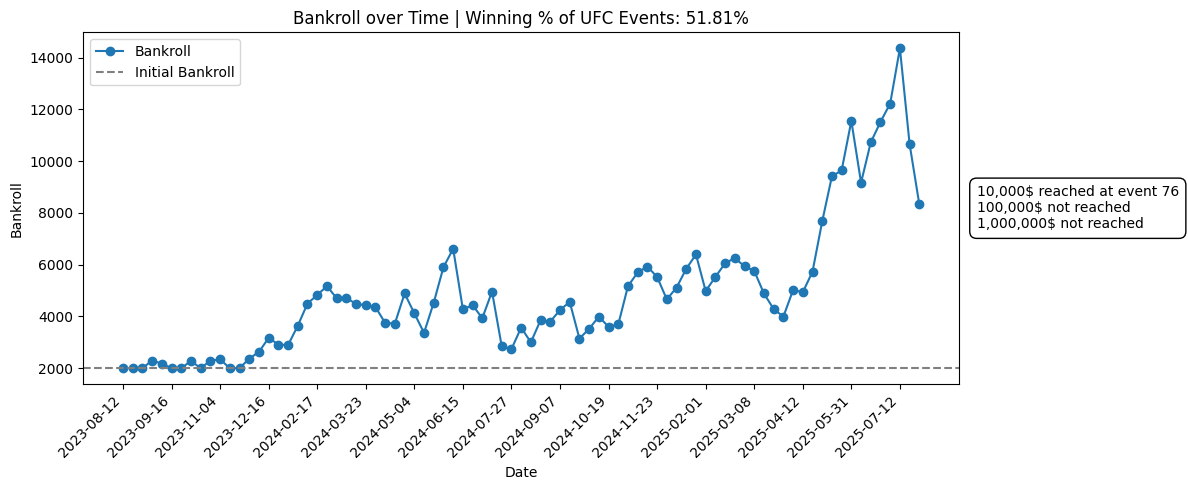

287.0411964329678
407.77957825146564
127.87994818827747
149.64764522163864
605.8481606144373
4.614768451957843


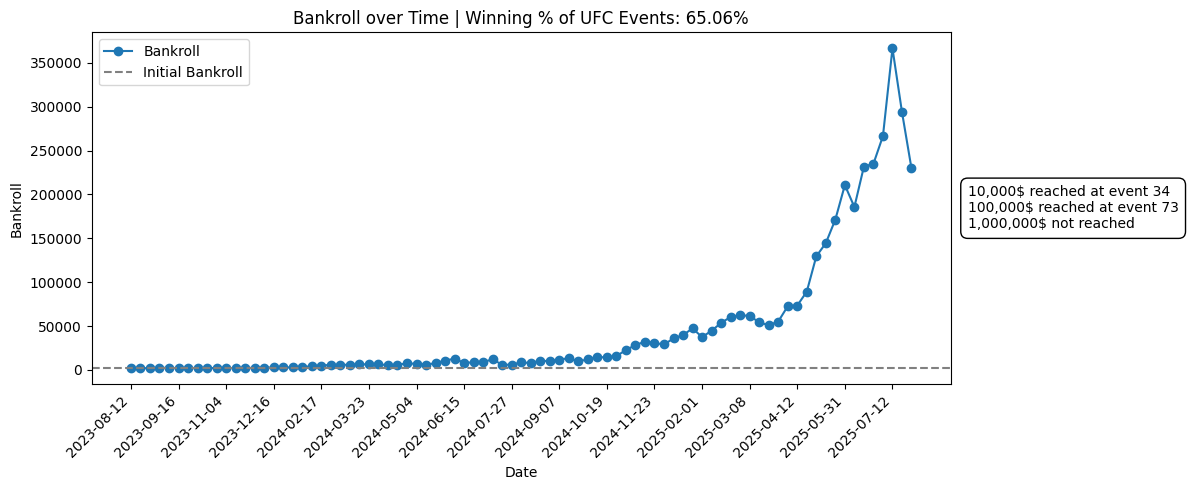

In [361]:
prob_cols = ['blue_probs', 'red_probs']
# fair_decimal_odds = ['dec_fair_open_blue', 'dec_fair_open_red']
fair_decimal_odds = ['dec_fair_close1_blue', 'dec_fair_close1_red']  # your decimal odds columns
real_decimal_odds = ['dec_close1_blue', 'dec_close1_red']
df_kelly1 = simulate_kelly(
    df_results,
    prob_cols=prob_cols,
    fair_decimal_cols=fair_decimal_odds,
    real_decimal_cols=real_decimal_odds,
    pred_winner_col='pred_winner',
    date_col='Date',
    init_bankroll=2000,
    bankroll_floor=100,
    portfolio_scaling=False,
    adaptive_scaling=True,
    max_drawdown=.4,
    N=1000,
    preds_history_dict=preds_results_dict,
    calc_parlay=False
)


prob_cols = ['blue_probs', 'red_probs']
# fair_decimal_odds = ['dec_fair_open_blue', 'dec_fair_open_red']
fair_decimal_odds = ['dec_fair_close2_blue', 'dec_fair_close2_red']  # your decimal odds columns
real_decimal_odds = ['dec_close2_blue', 'dec_close2_red']
df_kelly2 = simulate_kelly(
    df_results,
    prob_cols=prob_cols,
    fair_decimal_cols=fair_decimal_odds,
    real_decimal_cols=real_decimal_odds,
    pred_winner_col='pred_winner',
    date_col='Date',
    init_bankroll=2000,
    bankroll_floor=100,
    portfolio_scaling=False,
    adaptive_scaling=True,
    max_drawdown=.4,
    N=1000,
    preds_history_dict=preds_results_dict,
    calc_parlay=False
)



In [357]:
def summarize_line_movement(df):
    return (
        df.groupby('choice_close1')
        .agg(
            count=('net_odds', 'size'),
            avg_net_odds=('net_odds', 'mean'),
            avg_line_movement=('choice_close1', lambda x: (x - df.loc[x.index, 'choice_open']).mean())
        )
        .reset_index()
        .sort_values('choice_close1')
    )

# 1️⃣ Underdog → Favorite
df_ud_to_fav = df_kelly1[(df_kelly1['choice_close1'] > 0) & (df_kelly1['choice_open'] < 0)]
df_ud_to_fav['line_movement'] = df_ud_to_fav['choice_open'] - df_ud_to_fav['choice_close1'] 
table_ud_to_fav = summarize_line_movement(df_ud_to_fav)
print("📈 Line moved from underdog → favorite")
print(table_ud_to_fav, "\n")

# 2️⃣ Stayed Favorite
df_stayed_fav = df_kelly[(df_kelly['choice_open'] > 0) & (df_kelly['choice_close1'] > 0)]
df_stayed_fav['line_movement'] = df_stayed_fav['choice_open'] - df_stayed_fav['choice_close1'] 

table_stayed_fav = summarize_line_movement(df_stayed_fav)
print("🏆 Line stayed positive (favorite all along)")
print(table_stayed_fav, "\n")

# 3️⃣ Favorite → Underdog
df_fav_to_ud = df_kelly1[(df_kelly1['choice_open'] > 0) & (df_kelly1['choice_close1'] < 0)]

df_fav_to_ud['line_movement'] = df_fav_to_ud['choice_open'] - df_fav_to_ud['choice_close1'] 

table_fav_to_ud = summarize_line_movement(df_fav_to_ud)
print("📉 Line moved from favorite → underdog")
print(table_fav_to_ud)

📈 Line moved from underdog → favorite
   choice_close1  count  avg_net_odds  avg_line_movement
0          100.0      3     -0.333333         240.333333
1          105.0      5      0.210000         260.600000
2          110.0      2      0.000000         239.000000
3          115.0      3      0.383333         253.000000
4          116.0      1     -1.160000         221.000000
5          120.0      3      1.200000         246.666667
6          128.0      1      1.280000         238.000000
7          135.0      1     -1.350000         255.000000
8          150.0      1      1.500000         292.000000 

🏆 Line stayed positive (favorite all along)
    choice_close1  count  avg_net_odds  avg_line_movement
0           100.0      4     -0.450000         -11.250000
1           105.0      3      1.200000         -15.000000
2           106.0      1      1.050000           1.000000
3           108.0      1      1.200000         -12.000000
4           110.0      4      0.410000         -57.00000

C:\Users\jcmar\AppData\Local\Temp\ipykernel_28320\2574349914.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ud_to_fav['line_movement'] = df_ud_to_fav['choice_open'] - df_ud_to_fav['choice_close1']
C:\Users\jcmar\AppData\Local\Temp\ipykernel_28320\2574349914.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stayed_fav['line_movement'] = df_stayed_fav['choice_open'] - df_stayed_fav['choice_close1']
C:\Users\jcmar\AppData\Local\Temp\ipykernel_28320\2574349914.py:31: SettingWithCopyWarning: 
A va

c:\Users\jcmar\my_files\SportsBetting\venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\jcmar\my_files\SportsBetting\venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\Users\jcmar\my_files\SportsBetting\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jcmar\AppData\Local\Temp\ipykernel_28320\2254932933.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
c:\Users\jcmar\my_files\SportsBetting\ve

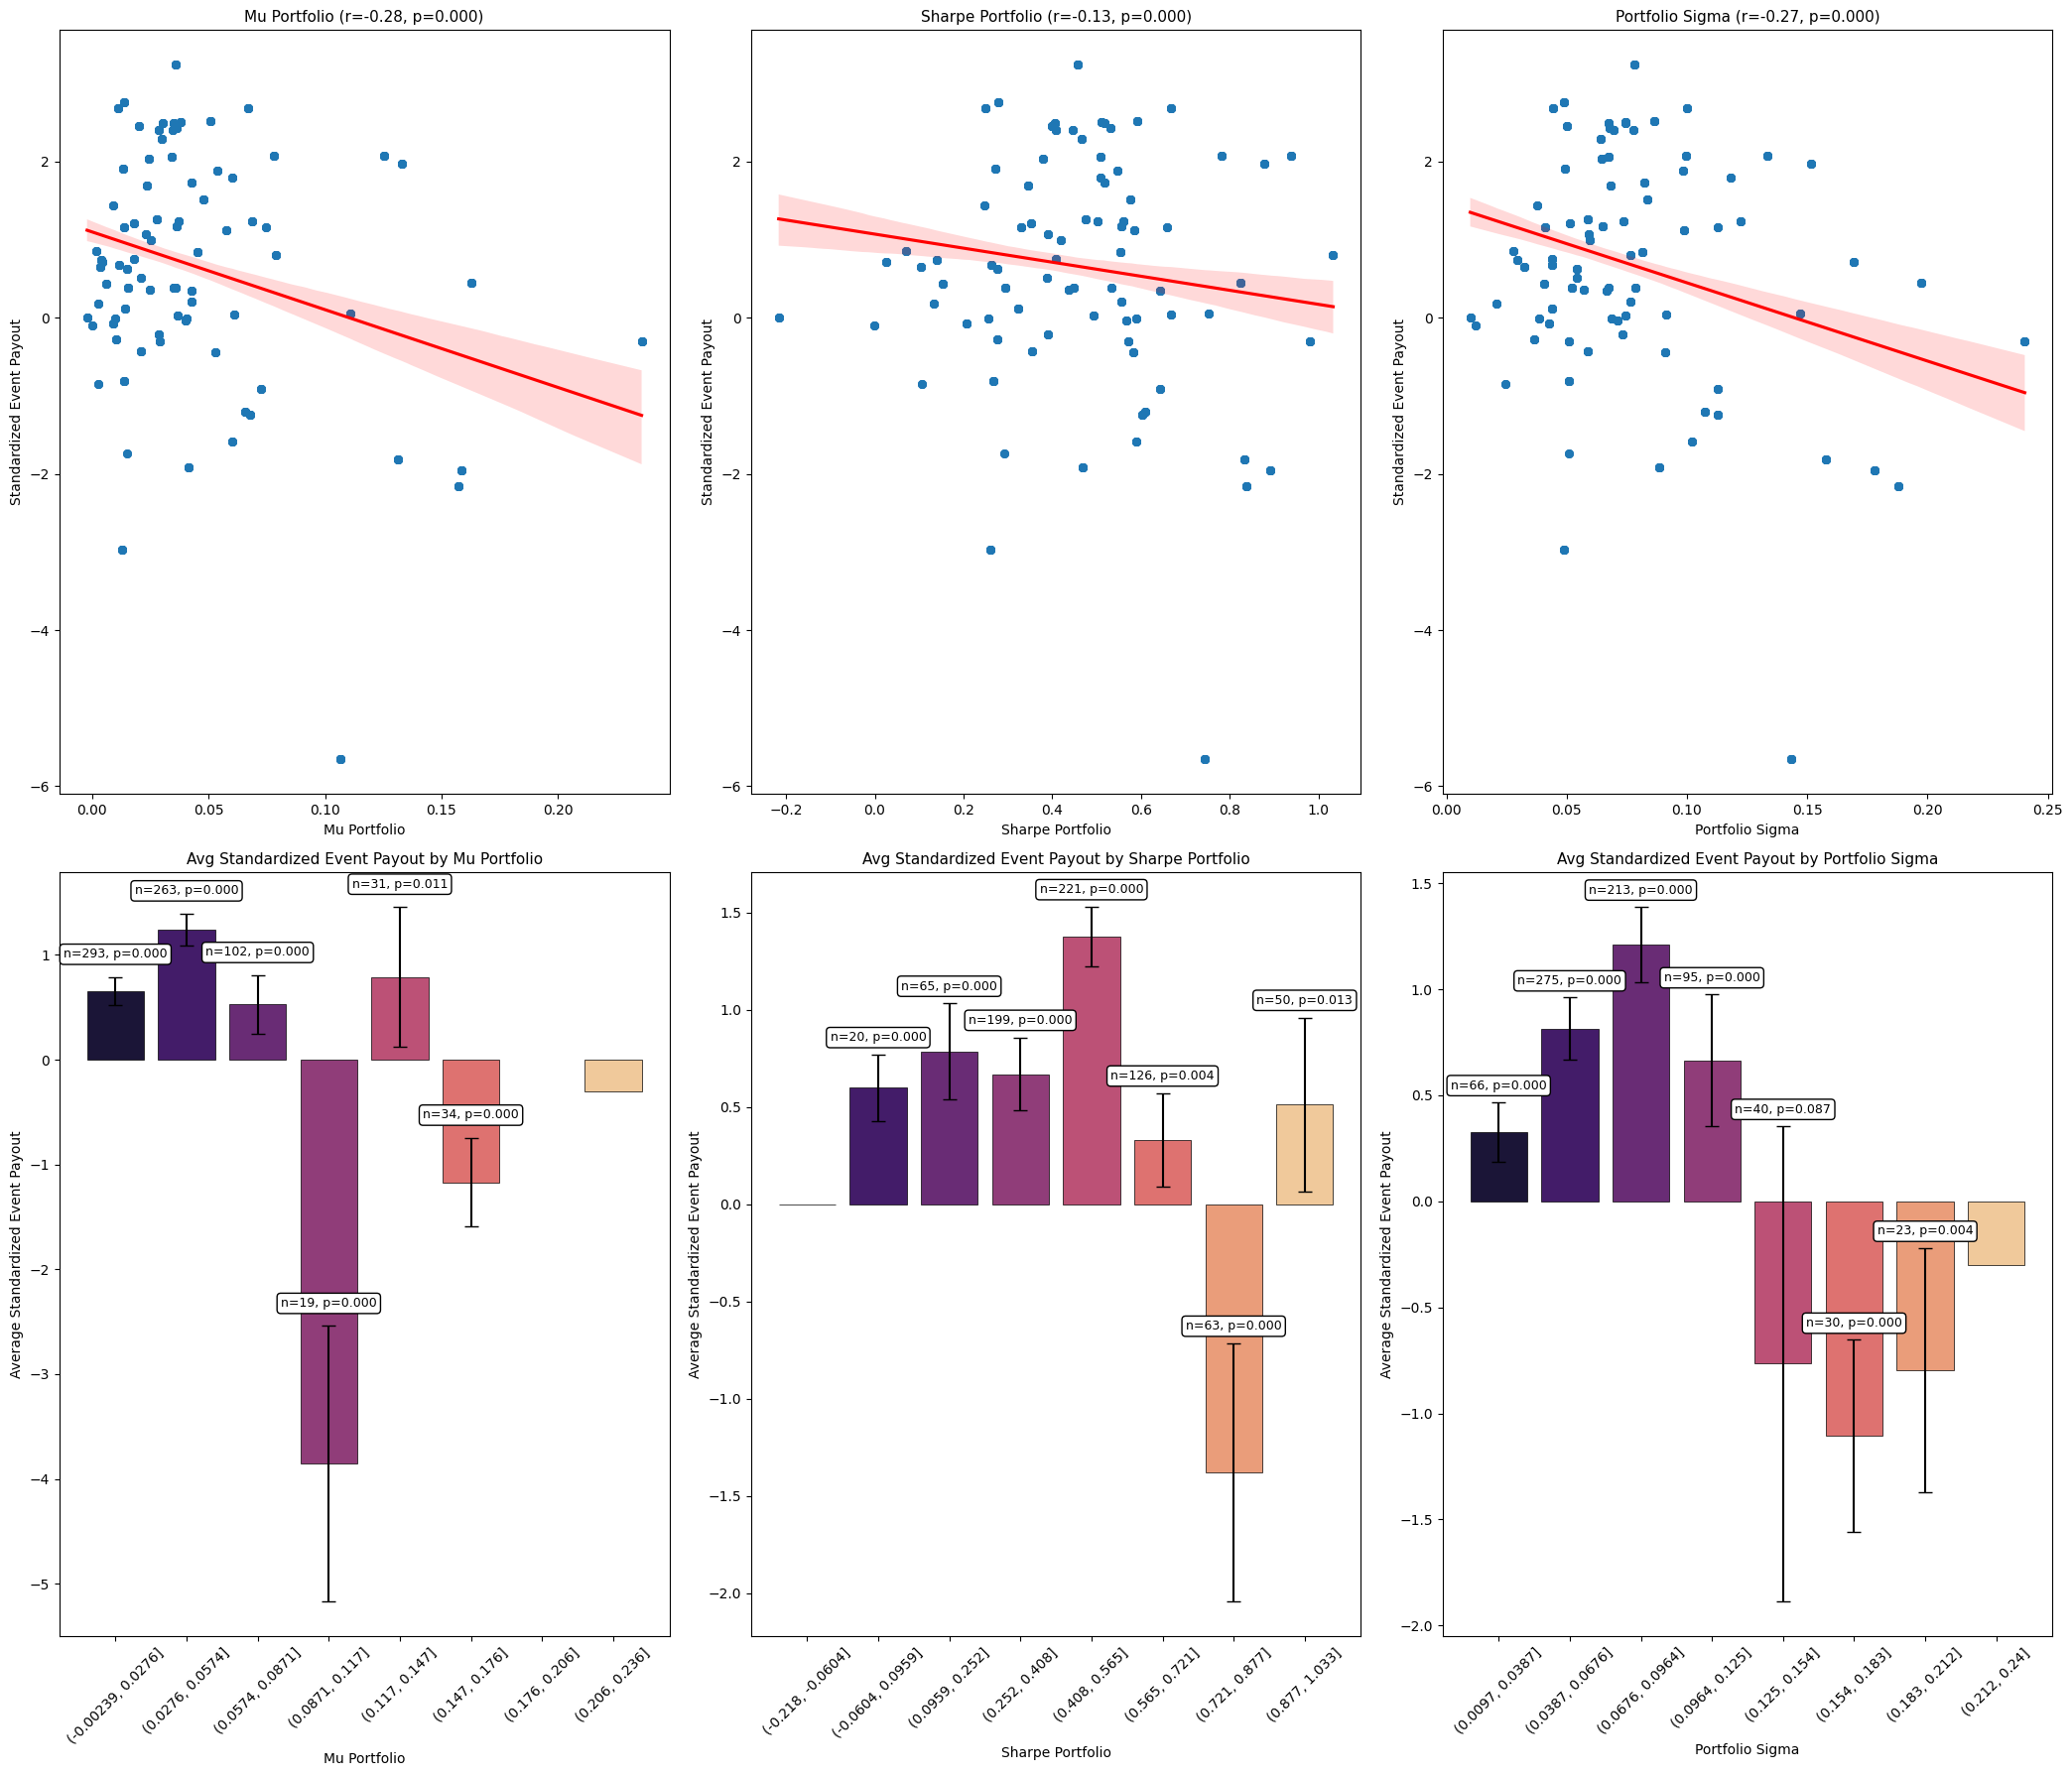

In [53]:
kelly_analysis(df_kelly1)

c:\Users\jcmar\my_files\SportsBetting\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\jcmar\my_files\SportsBetting\venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\jcmar\my_files\SportsBetting\venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\jcmar\AppData\Local\Temp\ipykernel_28320\2254932933.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
c:\Users\jcmar\my_files\SportsBetting\ve

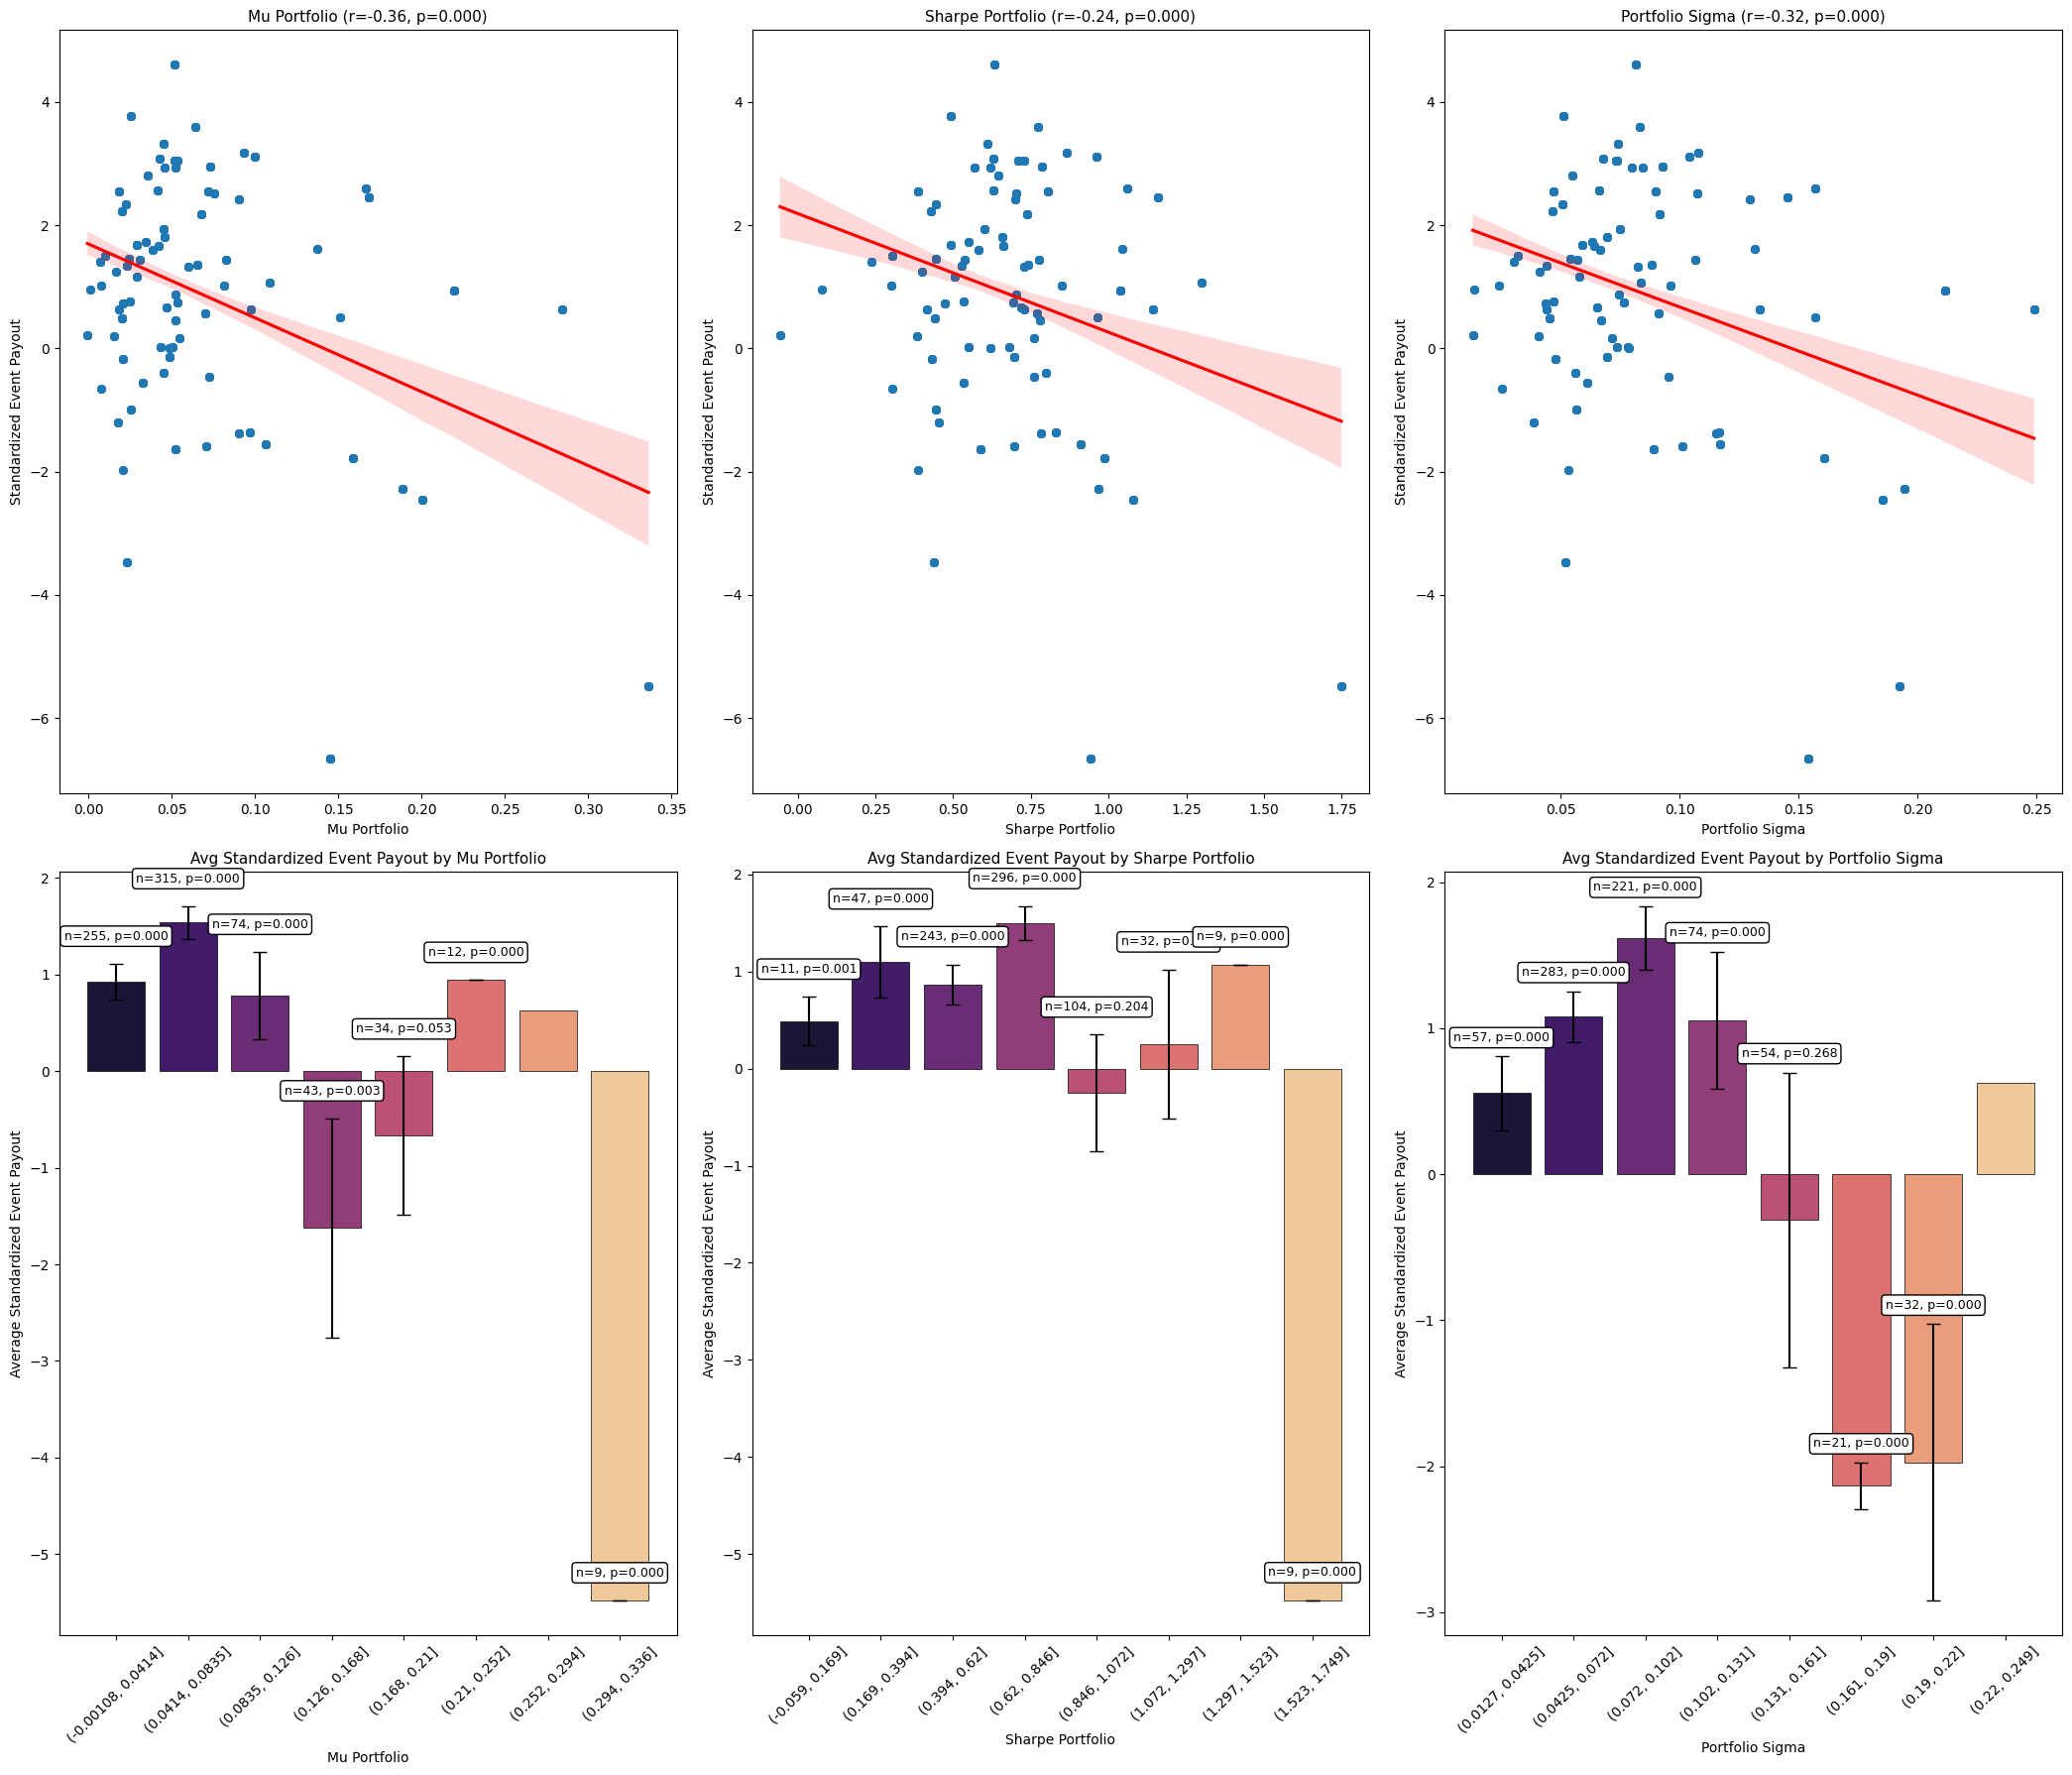

In [54]:
kelly_analysis(df_kelly2)

In [ ]:
dupes = df_results[df_results.duplicated(subset=["red_fighter", "blue_fighter", "Date"], keep=False)]
dupes[['red_fighter', 'blue_fighter', "Date", 'open_red', 'open_blue', 'pred_winner']]

,red_fighter,blue_fighter,Date,open_red,open_blue,pred_winner
708,hamdy abdelwahab,mohammed usman,2025-06-21,-150.0,110.0,1
709,hamdy abdelwahab,mohammed usman,2025-06-21,-150.0,110.0,1
710,tagir ulanbekov,azat maksum,2025-06-21,-280.0,230.0,1
711,tagir ulanbekov,azat maksum,2025-06-21,-280.0,230.0,1
712,irina alekseeva,klaudia sygula,2025-06-21,-188.0,140.0,1
713,irina alekseeva,klaudia sygula,2025-06-21,-188.0,140.0,1
714,rafael fiziev,ignacio bahamondes,2025-06-21,-130.0,110.0,0
716,rafael fiziev,ignacio bahamondes,2025-06-21,-130.0,110.0,0
740,max holloway,dustin poirier,2025-07-19,-130.0,110.0,1
741,max holloway,dustin poirier,2025-07-19,-130.0,110.0,1


C:\Users\jcmar\AppData\Local\Temp\ipykernel_72864\4145328875.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_results.groupby(['prob_bin', 'pred_winner'])['profit'].mean().unstack(fill_value=0)


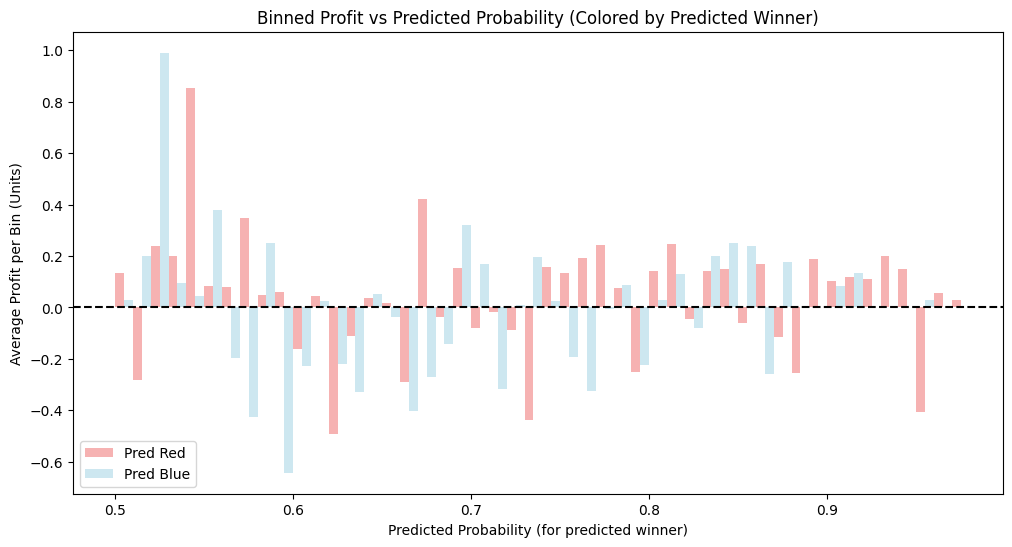

In [ ]:
def american_to_decimal(odds):
    return np.where(odds > 0, odds / 100 + 1, 100 / np.abs(odds) + 1)

def profit(row):
    pred = row['pred_winner']
    actual = row['winner']
    red_odds = row['dec_red']
    blue_odds = row['dec_blue']
    
    if pred == 1:  # bet on red
        return red_odds - 1 if actual == 1 else -1
    else:  # bet on blue
        return blue_odds - 1 if actual == 0 else -1
    
def profit_by_prob(df_results):
    df_results[['dec_red','dec_blue']] = df_results[['close1_red', 'close1_blue']].apply(american_to_decimal)
    df_results['profit'] = df_results.apply(profit, axis=1)

    # Predicted probability for the predicted fighter
    df_results['pred_prob'] = df_results.apply(
        lambda r: r['red_probs'] if r['pred_winner']==1 else r['blue_probs'],
        axis=1
    )

    # Create smaller bins
    bin_width = 0.01
    bins = np.arange(0, 1 + bin_width, bin_width)
    df_results['prob_bin'] = pd.cut(df_results['pred_prob'], bins=bins, labels=bins[:-1])

    # Aggregate profits per bin and predicted winner
    agg = df_results.groupby(['prob_bin', 'pred_winner'])['profit'].mean().unstack(fill_value=0)

    # Plot
    plt.figure(figsize=(12,6))
    bin_centers = bins[:-1] + bin_width/2
    plt.bar(bin_centers - bin_width/4, agg.get(1, 0), width=bin_width/2, color='lightcoral', alpha=0.6, label='Pred Red')
    plt.bar(bin_centers + bin_width/4, agg.get(0, 0), width=bin_width/2, color='lightblue', alpha=0.6, label='Pred Blue')

    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel("Predicted Probability (for predicted winner)")
    plt.ylabel("Average Profit per Bin (Units)")
    plt.title("Binned Profit vs Predicted Probability (Colored by Predicted Winner)")
    plt.legend()
    plt.show()

https://wayback.archive-it.org/5456/20240920160238/https://www.eecs.harvard.edu/cs286r/courses/fall12/papers/Thorpe_KellyCriterion2007.pdf

https://medium.com/raposa-technologies/how-to-use-python-and-the-kelly-criterion-to-optimize-your-stock-portfolio-bb6e43df50c2



In [ ]:
https://web3.arxiv.org/abs/2207.14124?utm_source=chatgpt.com

https://pubmed.ncbi.nlm.nih.gov/35205582/

https://summit.sfu.ca/item/34958?utm_source=chatgpt.com


https://www.glicko.net/glicko/glicko2.pdf

https://www.glicko.net/glicko.html

https://ojs.aaai.org/index.php/AIIDE/article/view/5233


https://arxiv.org/abs/2303.16741?utm_source=chatgpt.com

https://opisthokonta.net/?cat=48


https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling-dixon-coles-and-time-weighting/

